In [ ]:
!nvidia-smi #-lms 2000

Thu Apr 14 13:09:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import cv2
import re

In [ ]:
hImage, wImage = 1024, 1024
nClasses = 1
batch_size = 1
epochs = 10

feature_layers = [128, 64, 32, 16, 14, 12]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

def remove_images(df,images):
  """
  
  """
  df = df[df['image_name'].isin(images)]
  df.reset_index(inplace=True, drop=True)
  return df

def get_images_and_boxes(filename):
    ans = {}
    f = open(filename,"r")
    for line in f:
        line = line.strip().split(",")
        if(ans.get(line[0]) == None):
            ans[line[0]] = [[int(line[i]) for i in range(1,5)]]
        else:
            ans[line[0]].append([int(line[i]) for i in range(1,5)])
    f.close()
    return ans


def pre_process_data(path,images_and_boxes = {}):
  colnames=['image_name','x1','y1','x2','y2',\
            'class','image_width','image_height']
  
  annotate_data=pd.read_csv(path,header=None)
  annotate_data.columns = colnames
  annotate_data = remove_images(annotate_data,images_and_boxes.keys())
  tokenizer = tf.keras.preprocessing.text.Tokenizer()
  tokenizer.fit_on_texts(annotate_data['class'])
  idx=tokenizer.word_index
  print(idx)
  annotate_data = annotate_data.astype({"x1": float,\
                                        "x2": float,\
                                        "y1": float,\
                                        "y2": float})

  #Resize bb according to image
  annotate_data.iloc[:,1]=(annotate_data.iloc\
                           [:,1]*wImage)/annotate_data.iloc[:,6]
  annotate_data.iloc[:,2]=(annotate_data.iloc\
                           [:,2]*hImage)/annotate_data.iloc[:,7]
  annotate_data.iloc[:,3]=(annotate_data.iloc\
                           [:,3]*wImage)/annotate_data.iloc[:,6]
  annotate_data.iloc[:,4]=(annotate_data.iloc\
                           [:,4]*hImage)/annotate_data.iloc[:,7]
  
  annotate_data.iloc[:,5]=idx['object']
  annotate_data['label']=annotate_data\
  [['x1','y1','x2','y2','class']].to_numpy().tolist()

  #Converting to x,y,w,h
  annotate_data.iloc[:,1]=(annotate_data.iloc\
                           [:,1]+annotate_data.iloc[:,3])/2.0
  annotate_data.iloc[:,2]=(annotate_data.iloc\
                           [:,2]+annotate_data.iloc[:,4])/2.0
  annotate_data.iloc[:,3]=(annotate_data.iloc\
                           [:,3]-annotate_data.iloc[:,1])
  annotate_data.iloc[:,4]=(annotate_data.iloc\
                           [:,4]-annotate_data.iloc[:,2])
  annotate_data['boxes_xywh']=annotate_data\
  [['x1','y1','x2','y2','class']].to_numpy().tolist()
  annotate_data = annotate_data.groupby('image_name').\
  aggregate(lambda tdf: tdf.tolist())
  return annotate_data




test_images_names = list(get_images_and_boxes('/content/drive/MyDrive/Tesis/Datasets/SKU110k_512x512_reduced/annotations/annotations_test.csv').keys())


#val_path='/content/drive/MyDrive/Tesis/Datasets/SKU110k_512x512_reduced/annotations/annotations_val.csv'
val_path = '/content/drive/MyDrive/Tesis/Datasets/SKU110K_fixed/annotations/annotations_val.csv'
val_data=pre_process_data(val_path,get_images_and_boxes('/content/drive/MyDrive/Tesis/Datasets/SKU110k_512x512_reduced/annotations/annotations_val.csv'))
#path='/content/drive/MyDrive/Tesis/Datasets/SKU110k_512x512_reduced/annotations/annotations_train.csv'
path = '/content/drive/MyDrive/Tesis/Datasets/SKU110K_fixed/annotations/annotations_train.csv'
data=pre_process_data(path,get_images_and_boxes('/content/drive/MyDrive/Tesis/Datasets/SKU110k_512x512_reduced/annotations/annotations_train.csv'))
#test_path='/content/drive/MyDrive/Tesis/Datasets/SKU110k_512x512_reduced/annotations/annotations_test.csv'
test_path = '/content/drive/MyDrive/Tesis/Datasets/SKU110K_fixed/annotations/annotations_test.csv'
test_data=pre_process_data(test_path,get_images_and_boxes('/content/drive/MyDrive/Tesis/Datasets/SKU110k_512x512_reduced/annotations/annotations_test.csv'))


{'object': 1}
{'object': 1}
{'object': 1}


In [ ]:
print(len(val_data.iloc[0:]))
val_data.head()


588


,x1,y1,x2,y2,class,image_width,image_height,label,boxes_xywh
image_name,,,,,,,,,
val_0.jpg,"[49.0958904109589, 231.45205479452056, 293.917...","[374.2769230769231, 294.89230769230767, 297.10...","[46.9041095890411, 26.73972602739724, 30.02739...","[22.52307692307693, 32.49230769230769, 30.0307...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2336, 2336, 2336, 2336, 2336, 2336, 2336, 233...","[4160, 4160, 4160, 4160, 4160, 4160, 4160, 416...","[[2.191780821917808, 351.75384615384615, 96.0,...","[[49.0958904109589, 374.2769230769231, 46.9041..."
val_1.jpg,"[519.9477124183006, 921.3071895424837, 797.071...","[152.94117647058823, 184.47058823529412, 169.0...","[20.49673202614383, 42.039215686274474, 24.470...","[60.70588235294119, 37.64705882352942, 50.8235...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2448, 2448, 2448, 2448, 2448, 2448, 2448, 244...","[3264, 3264, 3264, 3264, 3264, 3264, 3264, 326...","[[499.45098039215685, 92.23529411764706, 540.4...","[[519.9477124183006, 152.94117647058823, 20.49..."
val_10.jpg,"[68.26666666666667, 537.3811965811965, 69.5794...","[237.53846153846155, 242.09230769230768, 254.6...","[58.639316239316244, 53.388034188034226, 59.95...","[7.876923076923077, 7.015384615384619, 7.26153...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2340, 2340, 2340, 2340, 2340, 2340, 2340, 234...","[4160, 4160, 4160, 4160, 4160, 4160, 4160, 416...","[[9.627350427350427, 229.66153846153847, 126.9...","[[68.26666666666667, 237.53846153846155, 58.63..."
val_100.jpg,"[484.3921568627451, 442.562091503268, 398.6405...","[359.05882352941177, 358.9019607843137, 359.52...","[17.986928104575156, 22.169934640522854, 22.16...","[33.725490196078454, 33.56862745098044, 34.196...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2448, 2448, 2448, 2448, 2448, 2448, 2448, 244...","[3264, 3264, 3264, 3264, 3264, 3264, 3264, 326...","[[466.4052287581699, 325.3333333333333, 502.37...","[[484.3921568627451, 359.05882352941177, 17.98..."
val_101.jpg,"[524.7581699346405, 353.6732026143791, 313.098...","[700.7058823529412, 689.8823529411765, 681.098...","[25.307189542483684, 14.013071895424844, 18.61...","[13.960784313725412, 29.803921568627402, 37.64...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2448, 2448, 2448, 2448, 2448, 2448, 2448, 244...","[3264, 3264, 3264, 3264, 3264, 3264, 3264, 326...","[[499.45098039215685, 686.7450980392157, 550.0...","[[524.7581699346405, 700.7058823529412, 25.307..."


In [ ]:
print(len(data.iloc[0:]))
data.head()

4109


,x1,y1,x2,y2,class,image_width,image_height,label,boxes_xywh
image_name,,,,,,,,,
train_0.jpg,"[106.66666666666667, 445.79894179894177, 405.6...","[228.74074074074076, 699.5978835978835, 717.88...","[36.23280423280424, 16.42328042328046, 21.3333...","[46.899470899470884, 48.42328042328052, 15.576...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3024, 3024, 3024, 3024, 3024, 3024, 3024, 302...","[3024, 3024, 3024, 3024, 3024, 3024, 3024, 302...","[[70.43386243386243, 181.84126984126985, 142.8...","[[106.66666666666667, 228.74074074074076, 36.2..."
train_1.jpg,"[301.8666666666667, 303.2, 363.73333333333335,...","[520.8, 573.4, 539.6, 508.20000000000005, 556....","[26.666666666666686, 28.0, 31.46666666666664, ...","[26.0, 23.399999999999977, 48.39999999999998, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1920, 1920, 1920, 1920, 1920, 1920, 1920, 192...","[2560, 2560, 2560, 2560, 2560, 2560, 2560, 256...","[[275.2, 494.8, 328.53333333333336, 546.8, 1.0...","[[301.8666666666667, 520.8, 26.666666666666686..."
train_10.jpg,"[620.1307189542483, 397.8039215686274, 576.836...","[436.54901960784315, 433.2549019607843, 434.03...","[20.287581699346447, 22.16993464052291, 15.477...","[40.0, 34.823529411764696, 44.39215686274514, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2448, 2448, 2448, 2448, 2448, 2448, 2448, 244...","[3264, 3264, 3264, 3264, 3264, 3264, 3264, 326...","[[599.843137254902, 396.54901960784315, 640.41...","[[620.1307189542483, 436.54901960784315, 20.28..."
train_100.jpg,"[111.05882352941177, 170.45751633986927, 295.9...","[347.45098039215685, 347.7647058823529, 347.92...","[28.235294117647044, 32.41830065359477, 29.071...","[36.23529411764707, 37.176470588235304, 34.509...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2448, 2448, 2448, 2448, 2448, 2448, 2448, 244...","[3264, 3264, 3264, 3264, 3264, 3264, 3264, 326...","[[82.82352941176471, 311.2156862745098, 139.29...","[[111.05882352941177, 347.45098039215685, 28.2..."
train_1000.jpg,"[262.27450980392155, 246.37908496732024, 220.6...","[732.5490196078431, 542.4313725490197, 546.196...","[35.97385620915037, 10.87581699346407, 12.7581...","[21.960784313725526, 40.15686274509801, 38.274...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2448, 2448, 2448, 2448, 2448, 2448, 2448, 244...","[3264, 3264, 3264, 3264, 3264, 3264, 3264, 326...","[[226.30065359477123, 710.5882352941177, 298.2...","[[262.27450980392155, 732.5490196078431, 35.97..."


In [ ]:
print(len(test_data.iloc[0:]))
test_data.head()

1468


,x1,y1,x2,y2,class,image_width,image_height,label,boxes_xywh
image_name,,,,,,,,,
test_0.jpg,"[72.15686274509804, 332.33986928104576, 246.37...","[829.9607843137255, 728.6274509803922, 738.509...","[21.960784313725497, 28.235294117647072, 52.70...","[37.17647058823525, 16.784313725490165, 25.098...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2448, 2448, 2448, 2448, 2448, 2448, 2448, 244...","[3264, 3264, 3264, 3264, 3264, 3264, 3264, 326...","[[50.19607843137255, 792.7843137254902, 94.117...","[[72.15686274509804, 829.9607843137255, 21.960..."
test_1.jpg,"[274.93333333333334, 306.4, 258.6666666666667,...","[192.4, 808.4000000000001, 823.0, 721.0, 722.2...","[31.19999999999999, 20.0, 26.133333333333326, ...","[18.0, 28.799999999999955, 15.0, 20.6000000000...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1920, 1920, 1920, 1920, 1920, 1920, 1920, 192...","[2560, 2560, 2560, 2560, 2560, 2560, 2560, 256...","[[243.73333333333332, 174.4, 306.1333333333333...","[[274.93333333333334, 192.4, 31.19999999999999..."
test_10.jpg,"[637.5931623931624, 20.348717948717947, 69.579...","[192.6153846153846, 132.55384615384617, 140.18...","[33.69572649572649, 18.16068376068376, 28.8820...","[15.384615384615387, 48.86153846153846, 50.830...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2340, 2340, 2340, 2340, 2340, 2340, 2340, 234...","[4160, 4160, 4160, 4160, 4160, 4160, 4160, 416...","[[603.8974358974359, 177.23076923076923, 671.2...","[[637.5931623931624, 192.6153846153846, 33.695..."
test_100.jpg,"[129.6, 61.33333333333333, 152.79999999999998,...","[264.20000000000005, 517.6, 514.8, 514.0, 478....","[41.06666666666666, 43.2, 42.93333333333334, 4...","[17.399999999999977, 18.0, 16.40000000000009, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1920, 1920, 1920, 1920, 1920, 1920, 1920, 192...","[2560, 2560, 2560, 2560, 2560, 2560, 2560, 256...","[[88.53333333333333, 246.8, 170.66666666666666...","[[129.6, 264.20000000000005, 41.06666666666666..."
test_1000.jpg,"[77.80392156862744, 30.5359477124183, 806.9019...","[735.8431372549019, 732.3921568627451, 447.686...","[23.42483660130719, 23.84313725490196, 23.4248...","[61.960784313725526, 64.78431372549016, 19.450...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2448, 2448, 2448, 2448, 2448, 2448, 2448, 244...","[3264, 3264, 3264, 3264, 3264, 3264, 3264, 326...","[[54.37908496732026, 673.8823529411765, 101.22...","[[77.80392156862744, 735.8431372549019, 23.424..."


In [ ]:
def read_img(img):
  with tf.io.gfile.GFile(img, 'rb') as fp:
    image = fp.read()
  return image

In [ ]:
def wrap_bytes(img):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[img]))

def wrap_float(value):
  return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def convert_tfrecord(images,labels,out_path,root):
  root='/content/drive/MyDrive/Tesis/Datasets/SKU110K_fixed/images'
  print(len(images))
  with tf.io.TFRecordWriter(out_path) as writer:
    for i in range(len(images)):
      image=os.path.join(root,images[i])
      if i%1000 == 0: print(i)
      img_bytes=read_img(image)
      sku={
            'image':wrap_bytes(img_bytes),
            'x':wrap_float(np.array(labels[i])[:,0]),
            'y':wrap_float(np.array(labels[i])[:,1]),
            'w':wrap_float(np.array(labels[i])[:,2]),
            'h':wrap_float(np.array(labels[i])[:,3]),
            'class':wrap_float(np.array(labels[i])[:,4])
      }
      feature=tf.train.Features(feature=sku)
      example=tf.train.Example(features=feature)
      serialized=example.SerializeToString()
      writer.write(serialized)

out_path='/content/val.tfrecords'
#convert_tfrecord(val_data.index,val_data['label'],out_path,'/content/drive/MyDrive/Tesis/Datasets/SKU110k_512x512_reduced/valid/images')

out_path='/content/train.tfrecords'
#convert_tfrecord(data.index,data['label'],out_path,'/content/drive/MyDrive/Tesis/Datasets/SKU110k_512x512_reduced/train/images')

out_path='/content/test.tfrecords'
#convert_tfrecord(test_data.index,test_data['label'],out_path,'/content/drive/MyDrive/Tesis/Datasets/SKU110k_512x512_reduced/test/images')

In [ ]:
def imshow(image):
    plt.figure(figsize=(8, 8))
    plt.imshow(image)

In [ ]:
def show_img(img,label):
  img = cv2.imread(img)
  color = (255,0,0)
  img = cv2.resize(img,(hImage,wImage))
  for i,val in enumerate(label):
    start = tuple((np.array(label[i][:2])).astype('int'))
    end = tuple((np.array(label[i][2:4])).astype('int'))
    cv2.rectangle(img,start,end,color,2)
  imshow(img)

In [ ]:
def convert_format(out,format):
  if format == 'x1y1x2y2':
    return tf.stack([out[...,0]-out[...,2]/2.0,
    out[...,1]-out[...,3]/2.0,
    out[...,0]+out[...,2]/2.0,
    out[...,1]+out[...,3]/2.0]
    ,axis=-1)

  elif format == 'xywh':
    return tf.stack([(out[...,0]+out[...,2])/2.0,
    (out[...,1]+out[...,3])/2.0,
    out[...,2]-out[...,0],
    out[...,3]-out[...,1],
    out[...,4]],axis=-1)  ##sending the class also



In [ ]:
def convert_scale(matrix,scale):
  if scale == 'abs':
    return tf.stack([matrix[:,0]*wImage,
    matrix[:,1]*hImage,
    matrix[:,2]*wImage,
    matrix[:,3]*hImage],axis=-1)

  elif scale == 'rel':
    return tf.stack([matrix[:,0]/wImage,
    matrix[:,1]/hImage,
    matrix[:,2]/wImage,
    matrix[:,3]/hImage],axis=-1)

In [ ]:
def normalised_ground_truth(matched_boxes,feature_box,return_format):
  matched_boxes = tf.cast(matched_boxes,dtype=tf.float32)
  feature_box = tf.cast(feature_box,dtype=tf.float32)
  if return_format == "encode":
    return tf.stack([(matched_boxes[:,0] - feature_box[:, 0]) / (feature_box[:, 2]),
                   (matched_boxes[:,1] - feature_box[:, 1]) / (feature_box[:, 3]),
        tf.math.log(matched_boxes[:,2] / feature_box[:, 2]),
        tf.math.log(matched_boxes[:,3] / feature_box[:, 3])],
        axis=-1) / [0.1, 0.1, 0.2, 0.2]

  elif return_format == "decode":
    matched_boxes *= [0.1, 0.1, 0.2, 0.2]
    return tf.stack([matched_boxes[:,0] * feature_box[:, 2] + (feature_box[:, 0]),
                    matched_boxes[:,1] * feature_box[:, 3] + (feature_box[:, 1]),
          tf.math.exp(matched_boxes[:,2]) * feature_box[:, 2],
          tf.math.exp(matched_boxes[:,3]) * feature_box[:, 3]],
          axis=-1)



In [ ]:
def create_df_box(feature_layers):
#   s_min+(s_max-s_min)/(m-1)*(k-1)
#   s_min = 0.2
#   s_max = 0.9
#   m = 6

#   scale=[]
#   for k in range(2,8):
#     sk = s_min+(s_max-s_min)/(m-1)*(k-1)
#     scale.append(sk)
#   scale.insert(0,s_min)
#   scale.extend([s_max])

  scale =  [0.03, 0.05, 0.08, 0.12, 0.15, 0.25, 0.35]

  feature_boxes=[]
  for feature_layer in feature_layers:
    if (feature_layer == 128 or feature_layer == 14 or feature_layer == 12):
    #   aspect_ratios=[1,2/3,1/2]
      aspect_ratios=[0.333, 0.416, 1.401]

    else:
    #   aspect_ratios=[1,2/3,3/2,1/2,1/3]
      aspect_ratios=[0.416, 0.553, 0.722, 1.401, 3.131]

    w_ar=[]
    h_ar=[]
    for i in aspect_ratios:
      if int(i) == 1:
        w=scale[feature_layers.index(feature_layer)]*np.sqrt(i)
        h=scale[feature_layers.index(feature_layer)]/np.sqrt(i)
        w_ar.append(w)
        h_ar.append(h)
        sk_1 = np.sqrt(scale[feature_layers.index(feature_layer)]* 
                     scale[feature_layers.index(feature_layer)+1])
        w = sk_1*np.sqrt(i)
        h = sk_1/np.sqrt(i)      
      else:
        w = scale[feature_layers.index(feature_layer)]*np.sqrt(i)
        h = scale[feature_layers.index(feature_layer)]/np.sqrt(i)
      w_ar.append(w)
      h_ar.append(h)
  
    x_axis = np.linspace(0,feature_layer,feature_layer+1)
    y_axis=np.linspace(0,feature_layer,feature_layer+1)
    xx,yy = np.meshgrid(x_axis,y_axis)
    x = [(i+0.5)/(feature_layer) for i in xx[:-1,:-1]]
    y = [(i+0.5)/(feature_layer) for i in yy[:-1,:-1]]

    if (feature_layer == 128 or feature_layer == 14 or feature_layer == 12):
      ndf_box = 4
    else:
      ndf_box = 6
    ndf_boxes = feature_layer*feature_layer*ndf_box
    nbox_coordinates = 4
    feature_box = np.zeros((ndf_boxes,nbox_coordinates))
    x = np.array(x).reshape(feature_layer*feature_layer)
    x = np.repeat(x,ndf_box)
    y = np.array(y).reshape(feature_layer*feature_layer)
    y = np.repeat(y,ndf_box)

    w_ar = np.tile(w_ar,feature_layer*feature_layer)
    h_ar = np.tile(h_ar,feature_layer*feature_layer)
    feature_box[:,0] = x
    feature_box[:,1] = y
    feature_box[:,2] = w_ar
    feature_box[:,3] = h_ar
    feature_boxes.append(feature_box)
  df_box = np.concatenate(feature_boxes,axis=0)
  return df_box

In [ ]:
def iou(box1,box2):
  box1 = tf.cast(box1,dtype=tf.float32)
  box2 = tf.cast(box2,dtype=tf.float32)
  
  x1 = tf.math.maximum(box1[:,None,0],box2[:,0])
  y1 = tf.math.maximum(box1[:,None,1],box2[:,1])
  x2 = tf.math.minimum(box1[:,None,2],box2[:,2])
  y2 = tf.math.minimum(box1[:,None,3],box2[:,3])
  
  #Intersection area
  intersectionArea = tf.math.maximum(0.0,x2-x1)*tf.math.maximum(0.0,y2-y1)

  #Union area
  box1Area = (box1[:,2]-box1[:,0])*(box1[:,3]-box1[:,1])
  box2Area = (box2[:,2]-box2[:,0])*(box2[:,3]-box2[:,1])
  
  unionArea = tf.math.maximum(1e-10,box1Area[:,None]+box2Area-intersectionArea)
  iou = intersectionArea/unionArea
  return tf.clip_by_value(iou,0.0,1.0)

In [ ]:
def df_match(labels,iou_matrix):
  max_values = tf.reduce_max(iou_matrix,axis=1)
  max_idx = tf.math.argmax(iou_matrix,axis=1)
  matched = tf.cast(tf.math.greater_equal(max_values,0.5),
                  dtype=tf.float32)
  gt_box = tf.gather(labels,max_idx)
  return gt_box,matched

In [ ]:
def pre_process_img(img,feature_box_conv,matched):
  img = cv2.imread(img)
  img = cv2.resize(img, (hImage,wImage), interpolation = cv2.INTER_AREA)
  color = (255,0,0)
  matched_idx = np.where(matched)
  for i in (matched_idx):
    for j in i:
      start = feature_box_conv[j,:2]
      end = feature_box_conv[j,2:4]
      start = tuple((start))
      end = tuple((end))
      cv2.rectangle(img,start,end,color,2)
  plt.title('Matched Boxes')
  imshow(img)

tf.Tensor(921, shape=(), dtype=int64)


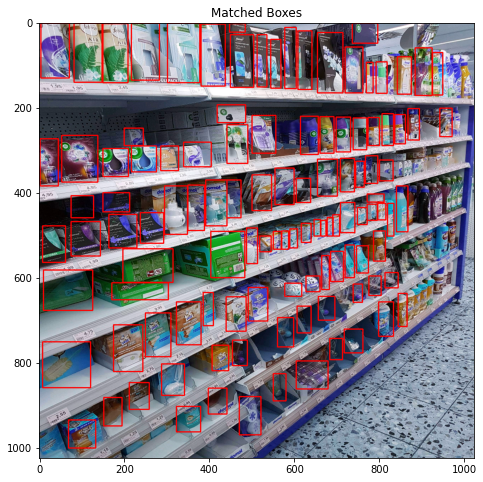

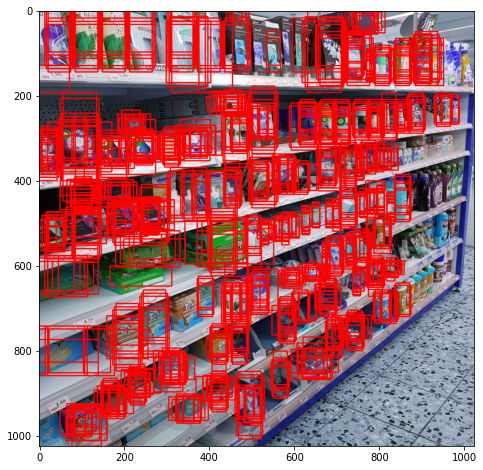

In [ ]:
#Matched Boxes
def create_data(data,root):
  i = 180
  images,labels = data.iloc[i].name,data.iloc[i]['label']
  # labels  x1y1x2y2
  root='/content/drive/MyDrive/Tesis/Datasets/SKU110K_fixed/images'

  images=os.path.join(root,images)
      
  #GT boxes creation
  img = images
  label = labels
  show_img(img,label)
  feature_box = create_df_box(feature_layers)
  feature_box = convert_scale(feature_box,'abs')
  feature_box_conv = convert_format(feature_box,'x1y1x2y2')
  iou_matrix = iou(feature_box_conv,np.array(label)[:,:4])
  gt_box,matched = df_match(convert_format(np.array(label),'xywh'),iou_matrix)
  # gt_box xywh
  print(tf.math.count_nonzero(matched))
  pre_process_img(img,convert_format(feature_box,'x1y1x2y2'),matched)
  boxes=gt_box[:,:4]
  classes = gt_box[:,4]
  classes = tf.cast(classes+1, dtype=tf.int32) #0 for background class
  matched = tf.cast(matched,dtype=tf.int32)
  classes = tf.cast(classes*matched,dtype=tf.int32)
  classes = tf.one_hot(classes,depth=nClasses+1,dtype=tf.float32)
  normalised_gtbox = normalised_ground_truth(boxes,feature_box,'encode')  
  normalised_gtbox = normalised_ground_truth(normalised_gtbox,feature_box,'decode')
  df_box = tf.concat((normalised_gtbox,classes),axis=-1)
  return df_box

df_box = create_data(data,'/content/drive/MyDrive/Tesis/Datasets/SKU110k_512x512_reduced/train/images')

In [ ]:
#label
feature_box = create_df_box(feature_layers)
feature_box = convert_scale(feature_box,'abs')
feature_box_conv = convert_format(feature_box,'x1y1x2y2')

def main(label):
  iou_matrix = iou(feature_box_conv,label)
  gt_box,matched = df_match(convert_format(label,'xywh'),iou_matrix)
  boxes = gt_box[:,:4]
  classes = gt_box[:,4]
  
  classes = tf.cast(classes+1, dtype=tf.int32) #0 for background class
  matched = tf.cast(matched,dtype=tf.int32)
  classes = tf.cast(classes*matched,dtype=tf.int32)
  classes = tf.one_hot(classes,depth=nClasses+1,dtype=tf.float32)
  normalised_gtbox = normalised_ground_truth(boxes,feature_box,'encode')
  df_box = tf.concat((normalised_gtbox,classes),axis=-1)
  df_box.set_shape([feature_box.shape[0], 4+nClasses+1])
  return df_box

In [ ]:
def convert_back(serialized):  
  feature={
      'image':tf.io.FixedLenFeature([],tf.string),
      'x':tf.io.VarLenFeature(tf.float32),
      'y':tf.io.VarLenFeature(tf.float32),
      'w':tf.io.VarLenFeature(tf.float32),
      'h':tf.io.VarLenFeature(tf.float32),
      'class':tf.io.VarLenFeature(tf.float32)
  }
  parsed_example = tf.io.parse_single_example(serialized=serialized,
                                            features=feature)
  img = tf.io.decode_image(parsed_example['image'],channels=3)
  img.set_shape([None,None,3])
  img = tf.image.resize(img,[hImage, wImage])
  img = tf.cast(img,tf.float32)
  # normalize image 
  img = tf.keras.applications.densenet.preprocess_input(img)

 
  label=tf.stack([tf.sparse.to_dense(parsed_example['x']),
            tf.sparse.to_dense(parsed_example['y']),
            tf.sparse.to_dense(parsed_example['w']),
            tf.sparse.to_dense(parsed_example['h']),
            tf.sparse.to_dense(parsed_example['class']) - 1],axis=-1)
  # label
  df_box = main(label)
  return img, df_box


def data_gen(files):
  autotune = tf.data.experimental.AUTOTUNE
  dataset=tf.data.TFRecordDataset(filenames=files)
  dataset = dataset.map(convert_back, num_parallel_calls=autotune)
  dataset = dataset.apply(tf.data.experimental.ignore_errors())
  dataset = dataset.shuffle(16)
  dataset = dataset.batch(batch_size, drop_remainder=True)
  dataset = dataset.repeat(epochs)
  dataset = dataset.prefetch(autotune)
  return dataset

#test_files='/content/test.tfrecords'
test_files = '/content/drive/MyDrive/Tesis/tfRecords/1024x1024_reduced/test.tfrecords'
test_dataset = data_gen(test_files)

#train_files='/content/train.tfrecords'
train_files = '/content/drive/MyDrive/Tesis/tfRecords/1024x1024_reduced/train.tfrecords'
train_dataset = data_gen(train_files)

#val_files='/content/val.tfrecords'
val_files = '/content/drive/MyDrive/Tesis/tfRecords/1024x1024_reduced/val.tfrecords'
val_dataset = data_gen(val_files)

In [ ]:
def total_loss(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    pos_mask = tf.cast(tf.equal(tf.squeeze(y_true[:, :, 4:5], axis=-1), 0.0),
                       tf.float32)
    num_pos = tf.maximum(
        1.0, tf.cast(tf.math.count_nonzero(pos_mask, axis=-1), tf.float32))
    loc_loss = tf.compat.v1.losses.huber_loss(labels=y_true[:, :, :4],
                                              predictions=y_pred[:, :, :4],
                                              reduction="none")

    loc_loss = tf.reduce_sum(loc_loss, axis=-1)
    loc_loss = tf.where(tf.equal(pos_mask, 1.0), loc_loss, 0.0)
    loc_loss = tf.reduce_sum(loc_loss, axis=-1)
    loc_loss = loc_loss / num_pos

    cce = tf.losses.CategoricalCrossentropy(from_logits=True,
                                            reduction=tf.losses.Reduction.NONE)
    cross_entropy = cce(y_true[:, :, 4:], y_pred[:, :, 4:])

    #neg:pos 3:1
    num_neg = 3.0 * num_pos

    #Negative Mining
    neg_cross_entropy = tf.where(tf.equal(pos_mask, 0.0), cross_entropy, 0.0)
    sorted_dfidx=tf.cast(tf.argsort(neg_cross_entropy,\
                            direction='DESCENDING',axis=-1),tf.int32)
    rank = tf.cast(tf.argsort(sorted_dfidx, axis=-1), tf.int32)
    num_neg = tf.cast(num_neg, dtype=tf.int32)
    neg_loss = tf.where(rank < tf.expand_dims(num_neg, axis=1),
                        neg_cross_entropy, 0.0)

    pos_loss = tf.where(tf.equal(pos_mask, 1.0), cross_entropy, 0.0)
    clas_loss = tf.reduce_sum(pos_loss + neg_loss, axis=-1)
    clas_loss = clas_loss / num_pos
    totalloss = loc_loss + clas_loss
    return totalloss

In [ ]:
def conv_layer(filter,kernel_size,
               layer,strides=1,
               padding='same',
               activation='linear',pool=False,
               poolsize=2,poolstride=2,conv=True):
  if conv == True:
      layer = tf.keras.layers.Conv2D(filters=filter,
                                  kernel_size=kernel_size,
                                  strides=strides,
                                  activation=activation,
                                  padding=padding,
                                  kernel_initializer='he_normal')(layer)
      layer = tf.keras.layers.BatchNormalization()(layer)
      layer = tf.keras.layers.ReLU()(layer)
  elif pool == True:
    layer=tf.keras.layers.MaxPool2D(pool_size=(poolsize,poolsize),
                                    strides=poolstride,padding='same')(layer)
  return layer

def ssd_model():
  outputs=[]
  densenet_121 = tf.keras.applications.DenseNet121(
                                            input_shape=(hImage, wImage, 3),
                                            include_top=False)
  
  #Feature Layer 1

  layer = densenet_121.get_layer('pool3_relu').output
  output = tf.keras.layers.Conv2D(filters=4*(4+nClasses+1),
            kernel_size=3,
            padding='same',
            kernel_initializer='glorot_normal')(layer)
  output = tf.keras.layers.Reshape([-1, 4+nClasses+1])(output)
  outputs.append(output)
  
  #Feature Layer 2

  layer = densenet_121.get_layer('pool4_relu').output
  output = tf.keras.layers.Conv2D(filters=6*(4+nClasses+1),
            kernel_size=3,
            padding='same',
            kernel_initializer='glorot_normal')(layer)
  output = tf.keras.layers.Reshape([-1, 4+nClasses+1])(output)
  outputs.append(output)


  #Feature Layer 3 
  
  layer = densenet_121.get_layer('relu').output
  output = tf.keras.layers.Conv2D(filters=6*(4+nClasses+1),
          kernel_size=3,
          padding='same',
          kernel_initializer='glorot_normal')(layer)
  output = tf.keras.layers.Reshape([-1, 4+nClasses+1])(output)
  outputs.append(output)

  #Feature Layer 4

  layer = conv_layer(128, 1, layer)
  layer = conv_layer(256, 3, layer, strides=2)
  output = tf.keras.layers.Conv2D(filters=6*(4+nClasses+1),
          kernel_size=3,
          padding='same',
          kernel_initializer='glorot_normal')(layer)
  output = tf.keras.layers.Reshape([-1, 4+nClasses+1])(output)
  outputs.append(output)
  
  #Feature Layer 5 

  layer = conv_layer(128, 1, layer,padding= 'valid')
  layer = conv_layer(256, 3, layer,padding= 'valid')
  output = tf.keras.layers.Conv2D(filters=4*(4+nClasses+1),
          kernel_size=3,
          padding='same',
          kernel_initializer='glorot_normal')(layer)
  output = tf.keras.layers.Reshape([-1, 4+nClasses+1])(output)
  outputs.append(output)
                 
  #Feature Layer 6 

  layer = conv_layer(128, 1, layer,padding= 'valid')
  layer = conv_layer(256, 3, layer,padding= 'valid')
  output = tf.keras.layers.Conv2D(filters=4*(4+nClasses+1),
        kernel_size=3,
        padding='same',
        kernel_initializer='glorot_normal')(layer)
  output = tf.keras.layers.Reshape([-1, 4+nClasses+1])(output)
  outputs.append(output)

  out = tf.keras.layers.Concatenate(axis=1)(outputs)
  model = tf.keras.models.Model(densenet_121.input,out, name='SSD')
  model.summary()
  return model

In [51]:
"""
if optimizer == "adam":
      optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
  elif optimizer == "sgd":
      optimizer = tf.optimizers.SGD(learning_rate=learning_rate)
  elif optimizer=='rmsprop':
      optimizer = tf.optimizers.RMSprop(learning_rate=learning_rate)
  else:
      raise ValueError("unexpected optimizer name")
"""
learning_rate = 0.0001
optimizer = tf.optimizers.SGD(learning_rate=learning_rate)

model = ssd_model()

model.compile(optimizer=optimizer,
            loss=total_loss)

# callback=tf.keras.callbacks.ModelCheckpoint(
#         filepath='/content/drive/My Drive/tanya/ssd_sku/ssd_model_{epoch:02d}.h5',
#         monitor='loss',
#         save_best_only=False,
#         save_weights_only=True,
#         mode='min',
#         verbose=1)

step_per_epoch = len(data)//batch_size
val_steps = len(val_data)//batch_size

Model: "SSD"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 1024, 1024,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d_10 (ZeroPadding  (None, 1030, 1030,   0          ['input_6[0][0]']                
 2D)                            3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, 512, 512, 64  9408        ['zero_padding2d_10[0][0]']      
                                )                                                               

In [52]:
%%time
checkpoint_path = "/content/cp_run0.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_best_only=True)

epochs = 5
model.fit(train_dataset,           
          epochs=epochs,
          validation_data=val_dataset,
          steps_per_epoch=step_per_epoch,
          validation_steps=val_steps,
          callbacks=[cp_callback])

Epoch 1/5
4109/4109 [==============================] - ETA: 0s - loss: 6.1486
Epoch 1: val_loss improved from inf to 5.46840, saving model to /content/cp_run0.ckpt
4109/4109 [==============================] - 1160s 280ms/step - loss: 6.1486 - val_loss: 5.4684
Epoch 2/5
4109/4109 [==============================] - ETA: 0s - loss: 5.3129
Epoch 2: val_loss improved from 5.46840 to 5.15810, saving model to /content/cp_run0.ckpt
4109/4109 [==============================] - 1152s 280ms/step - loss: 5.3129 - val_loss: 5.1581
Epoch 3/5
4109/4109 [==============================] - ETA: 0s - loss: 5.1004
Epoch 3: val_loss improved from 5.15810 to 5.01770, saving model to /content/cp_run0.ckpt
4109/4109 [==============================] - 1151s 280ms/step - loss: 5.1004 - val_loss: 5.0177
Epoch 4/5
4109/4109 [==============================] - ETA: 0s - loss: 4.9850
Epoch 4: val_loss improved from 5.01770 to 4.92076, saving model to /content/cp_run0.ckpt
4109/4109 [==============================] -

In [53]:
def decode(y_pred,df_box):
  y_preds = tf.squeeze(y_pred,axis=0)
  df_box = tf.cast(df_box,dtype=tf.float32)
  boxes = y_preds[:,:4]
  boxes = normalised_ground_truth(boxes,df_box,'decode')
  boxes_x1y1 = convert_format(boxes,'x1y1x2y2')
  y_preds = tf.nn.softmax(y_preds[:,4:])
  cls_idx = tf.argmax(y_preds, axis=-1)
  cls_scores = tf.reduce_max(y_preds, axis=-1)
  #Filter out the backgrund class
  foreground_idx = tf.where(cls_idx != 0)[:, 0]
  #print(foreground_idx.shape)

  filtered_boxes = tf.gather(boxes_x1y1, foreground_idx)
  filtered_cls_idx = tf.gather(cls_idx, foreground_idx)
  filtered_cls_scores = tf.gather(cls_scores, foreground_idx)
  filtered_cls_idx = filtered_cls_idx-1

  filtered_boxes_y1x1 = tf.stack([filtered_boxes[:,1],
                                filtered_boxes[:,0],
                                filtered_boxes[:,3],
                                filtered_boxes[:,2]],axis=-1)  
  nms_idx = tf.image.non_max_suppression(filtered_boxes_y1x1,
                                          filtered_cls_scores,
                                          max_output_size=200,
                                          iou_threshold=0.5,
                                          score_threshold=1e-2)
  final_boxes = tf.gather(filtered_boxes, nms_idx)
  final_cls_idx = tf.gather(filtered_cls_idx, nms_idx)
  final_cls_scores = tf.gather(filtered_cls_scores, nms_idx)
  return final_boxes, final_cls_idx, final_cls_scores

In [54]:
def visualize_detections(image, boxes, classes, scores):
  figsize=(10, 10)
  linewidth=1
  color=[0, 0, 1]
  image = np.array(image, dtype=np.uint8)
  plt.figure(figsize=figsize)
  plt.axis('off')
  plt.imshow(image)
  ax = plt.gca()
  for box, _cls, score in zip(boxes, classes, scores):
      text = '{}: {:.2f}'.format(_cls, score)
      x1, y1, x2, y2 = box
      w, h = x2 - x1, y2 - y1
      patch = plt.Rectangle([x1, y1], w, h, fill=False, 
                            edgecolor=color, linewidth=linewidth)
      ax.add_patch(patch)
      #ax.text(x1, y1, text, bbox={'facecolor':color, 'alpha':0.4}, 
      #        clip_box=ax.clipbox, clip_on=True)

In [55]:
class_map = {
    1: 'product'
}
test_images = os.listdir("/content/drive/MyDrive/Tesis/testImages/images")
for i in range(len(test_images)):
  #image,label = test_data.iloc[i].name,test_data.iloc[i]['label']
  image = test_images[i]
  root='/content/drive/MyDrive/Tesis/testImages/images'

  image_path=os.path.join(root,image)
  
  image = cv2.imread(image_path,3)#,cv2.COLOR_BGR2RGB)
  b,g,r = cv2.split(image)           # get b, g, r
  image = cv2.merge([r,g,b])     # switch it to r, g, b
  #plt.imshow(image)
  image = cv2.resize(image, (hImage,wImage))

  image_ = tf.keras.applications.densenet.preprocess_input(image)

  #label = main(np.array(label))

  predictions = model(image_[None, ...], training=False)
  feature_box=create_df_box(feature_layers)
  feature_box=convert_scale(feature_box,'abs')
  final_boxes, final_cls_idx, final_cls_scores = decode(predictions,feature_box)
  visualize_detections(image, final_boxes, final_cls_idx, final_cls_scores)

#Test model

In [ ]:
#saved weights
checkpoint_path = "/content/cp_run3.ckpt"
optimizer = tf.optimizers.Adam(learning_rate=0.001)

model = ssd_model()

model.compile(optimizer=optimizer,
            loss=total_loss)

model.load_weights(checkpoint_path)

Model: "SSD"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1024, 1024,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d_4 (ZeroPadding2  (None, 1030, 1030,   0          ['input_3[0][0]']                
 D)                             3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, 512, 512, 64  9408        ['zero_padding2d_4[0][0]']       
                                )                                                               

In [ ]:
def read_images_IQA(filename):
  f,ans = open(filename,"r"),list()
  for line in f:
    ans.append(line.strip().split()[1])
  f.close()
  return ans

In [56]:

import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
from itertools import product
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


#https://towardsdatascience.com/evaluating-performance-of-an-object-detection-model-137a349c517b
INF = float('inf')

test_images_names = list(test_images_names)

def transform(data,tg_size,img):
    ans = []
    y_ = img.shape[0]
    x_ = img.shape[1]
    x_scale = tg_size / x_
    y_scale = tg_size / y_
    for xmin,ymin,xmax,ymax in data:
        (origLeft, origTop, origRight, origBottom) = (xmin,ymin,xmax,ymax)
        xmin = int(np.round(origLeft * x_scale))
        ymin = int(np.round(origTop * y_scale))
        xmax = int(np.round(origRight * x_scale))
        ymax = int(np.round(origBottom * y_scale))
        
        
        #if( x1 <= x2 and y1 <= y2): 
        ans.append([xmin,ymin,xmax,ymax])

    return ans


def drawBox(boxes, image):
    for i in range (0, len(boxes)):
        cv2.rectangle(image,(boxes[i][0],boxes[i][1]),(boxes[i][2],boxes[i][3]),(255, 0, 0),1)
    b,g,r = cv2.split(image)           # get b, g, r
    image = cv2.merge([r,g,b])     # switch it to r, g, b
        
    #cv2.namedWindow('final', cv2.WINDOW_NORMAL)
    cv2_imshow(image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def get_model_scores(pred_boxes):
    """Creates a dictionary of from model_scores to image ids.
    Args:
        pred_boxes (dict): dict of dicts of 'boxes' and 'scores'
    Returns:
        dict: keys are model_scores and values are image ids (usually filenames)
    """
    model_score={}
    for img_id, val in pred_boxes.items():
        for score in val['scores']:
            if score not in model_score.keys():
                model_score[score]=[img_id]
            else:
                model_score[score].append(img_id)
    return model_score

def calc_iou( gt_bbox, pred_bbox):
    '''
    This function takes the predicted bounding box and ground truth bounding box and 
    return the IoU ratio
    '''
    x_topleft_gt, y_topleft_gt, x_bottomright_gt, y_bottomright_gt= gt_bbox
    x_topleft_p, y_topleft_p, x_bottomright_p, y_bottomright_p= pred_bbox
    
    if (x_topleft_gt > x_bottomright_gt) or (y_topleft_gt> y_bottomright_gt):
        return 0
        #raise AssertionError("Ground Truth Bounding Box is not correct")
    if (x_topleft_p > x_bottomright_p) or (y_topleft_p> y_bottomright_p):
        #print("Predicted Bounding Box is not correct",x_topleft_p, x_bottomright_p,y_topleft_p,y_bottomright_gt)
        return 0
        #raise AssertionError("Predicted Bounding Box is not correct",x_topleft_p, x_bottomright_p,y_topleft_p,y_bottomright_gt)
        
         
    #if the GT bbox and predcited BBox do not overlap then iou=0
    if(x_bottomright_gt< x_topleft_p):
        # If bottom right of x-coordinate  GT  bbox is less than or above the top left of x coordinate of  the predicted BBox
        
        return 0.0
    if(y_bottomright_gt< y_topleft_p):  # If bottom right of y-coordinate  GT  bbox is less than or above the top left of y coordinate of  the predicted BBox
        
        return 0.0
    if(x_topleft_gt> x_bottomright_p): # If bottom right of x-coordinate  GT  bbox is greater than or below the bottom right  of x coordinate of  the predcited BBox
        
        return 0.0
    if(y_topleft_gt> y_bottomright_p): # If bottom right of y-coordinate  GT  bbox is greater than or below the bottom right  of y coordinate of  the predcited BBox
        
        return 0.0
    
    
    GT_bbox_area = (x_bottomright_gt -  x_topleft_gt + 1) * (  y_bottomright_gt -y_topleft_gt + 1)
    Pred_bbox_area =(x_bottomright_p - x_topleft_p + 1 ) * ( y_bottomright_p -y_topleft_p + 1)
    
    x_top_left =np.max([x_topleft_gt, x_topleft_p])
    y_top_left = np.max([y_topleft_gt, y_topleft_p])
    x_bottom_right = np.min([x_bottomright_gt, x_bottomright_p])
    y_bottom_right = np.min([y_bottomright_gt, y_bottomright_p])
    
    intersection_area = (x_bottom_right- x_top_left + 1) * (y_bottom_right-y_top_left  + 1)
    
    union_area = (GT_bbox_area + Pred_bbox_area - intersection_area)
   
    return intersection_area/union_area

def calc_precision_recall(image_results):
    """Calculates precision and recall from the set of images
    Args:
        img_results (dict): dictionary formatted like:
            {
                'img_id1': {'true_pos': int, 'false_pos': int, 'false_neg': int},
                'img_id2': ...
                ...
            }
    Returns:
        tuple: of floats of (precision, recall)
    """
    true_positive=0
    false_positive=0
    false_negative=0
    for img_id, res in image_results.items():
        true_positive +=res['true_positive']
        false_positive += res['false_positive']
        false_negative += res['false_negative']
        try:
            precision = true_positive/(true_positive+ false_positive)
        except ZeroDivisionError:
            precision=0.0
        try:
            recall = true_positive/(true_positive + false_negative)
        except ZeroDivisionError:
            recall=0.0
    return (precision, recall)


def get_single_image_results(gt_boxes, pred_boxes, iou_thr):
    """Calculates number of true_pos, false_pos, false_neg from single batch of boxes.
    Args:
        gt_boxes (list of list of floats): list of locations of ground truth
            objects as [xmin, ymin, xmax, ymax]
        pred_boxes (dict): dict of dicts of 'boxes' (formatted like `gt_boxes`)
            and 'scores'
        iou_thr (float): value of IoU to consider as threshold for a
            true prediction.
    Returns:
        dict: true positives (int), false positives (int), false negatives (int)
    """
    all_pred_indices= range(len(pred_boxes))
    all_gt_indices=range(len(gt_boxes))
    if len(all_pred_indices)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    if len(all_gt_indices)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    
    gt_idx_thr=[]
    pred_idx_thr=[]
    ious=[]
    for ipb, pred_box in enumerate(pred_boxes):
        for igb, gt_box in enumerate(gt_boxes):
            iou= calc_iou(gt_box, pred_box)
            
            if iou >iou_thr:
                gt_idx_thr.append(igb)
                pred_idx_thr.append(ipb)
                ious.append(iou)
    iou_sort = np.argsort(ious)[::1]
    if len(iou_sort)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    else:
        gt_match_idx=[]
        pred_match_idx=[]
        for idx in iou_sort:
            gt_idx=gt_idx_thr[idx]
            pr_idx= pred_idx_thr[idx]
            # If the boxes are unmatched, add them to matches
            if(gt_idx not in gt_match_idx) and (pr_idx not in pred_match_idx):
                gt_match_idx.append(gt_idx)
                pred_match_idx.append(pr_idx)
        tp= len(gt_match_idx)
        fp= len(pred_boxes) - len(pred_match_idx)
        fn = len(gt_boxes) - len(gt_match_idx)
    return {'true_positive': tp, 'false_positive': fp, 'false_negative': fn}

def  get_avg_precision_at_iou(gt_boxes, pred_bb, iou_thr=0.5):
    
    model_scores = get_model_scores(pred_bb)
    sorted_model_scores= sorted(model_scores.keys())# Sort the predicted boxes in descending order (lowest scoring boxes first):
    for img_id in pred_bb.keys():
        
        arg_sort = np.argsort(pred_bb[img_id]['scores'])
        pred_bb[img_id]['scores'] = np.array(pred_bb[img_id]['scores'])[arg_sort].tolist()
        pred_bb[img_id]['boxes'] = np.array(pred_bb[img_id]['boxes'])[arg_sort].tolist()
    pred_boxes_pruned = deepcopy(pred_bb)
        
    
    precisions = []
    recalls = []
    model_thrs = []
    img_results = {}# Loop over model score thresholds and calculate precision, recall
    for ithr, model_score_thr in enumerate(sorted_model_scores[:-1]):
            # On first iteration, define img_results for the first time:
        #print("Model score : ", model_score_thr)
        img_ids = gt_boxes.keys() if ithr == 0 else model_scores[model_score_thr]
        for img_id in img_ids:
            #print("Image {0} processed".format(img_id))
            gt_boxes_img = gt_boxes[img_id]
            box_scores = pred_boxes_pruned[img_id]['scores']
            start_idx = 0
            for score in box_scores:
                if score <= model_score_thr:
                    pred_boxes_pruned[img_id]
                    start_idx += 1
                else:
                    break 
            # Remove boxes, scores of lower than threshold scores:
            pred_boxes_pruned[img_id]['scores']= pred_boxes_pruned[img_id]['scores'][start_idx:]
            pred_boxes_pruned[img_id]['boxes']= pred_boxes_pruned[img_id]['boxes'][start_idx:]# Recalculate image results for this image
            #print(img_id)
            img_results[img_id] = get_single_image_results(gt_boxes_img, pred_boxes_pruned[img_id]['boxes'], iou_thr)# calculate precision and recall
        prec, rec = calc_precision_recall(img_results)
        precisions.append(prec)
        recalls.append(rec)
        model_thrs.append(model_score_thr)
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    prec_at_rec = []
    print("Processing recall...")
    for recall_level in np.linspace(0.0, 1.0, 11):
        try:
            args= np.argwhere(recalls>recall_level).flatten()
            prec= max(precisions[args])
            #print(recalls,"Recall")
            #print(      recall_level,"Recall Level")
            #print(       args, "Args")
            #print(       prec, "precision")
        except ValueError:
            prec=0.0
        prec_at_rec.append(prec)
    avg_prec = np.mean(prec_at_rec) 
    return {
        'avg_prec': avg_prec,
        'precisions': precisions,
        'recalls': recalls,
        'model_thrs': model_thrs}


def compare(path_images,filename,selected_images=None):
    global test_images_names
    f1 = lambda x,y: (2*x*y)/(x+y)
    i = 0
    gt_boxes = {}
    pred_boxes = {}
    images_and_boxes = get_images_and_boxes(filename)
    image_results = {}
    #print(test_images_names)
    if(selected_images != None):
      test_images_names = [f for f in test_images_names if f in selected_images]
      print(test_images_names)
    while i < len(test_images_names):
      
        image = cv2.imread(path_images+"/"+test_images_names[i],3)#,cv2.COLOR_BGR2RGB)
        
        real_boxes = transform(images_and_boxes[test_images_names[i]],1024,image)
        
       
        gt_boxes[test_images_names[i]] = [list(bbox) for bbox in real_boxes]


        b,g,r = cv2.split(image)           # get b, g, r
        image = cv2.merge([r,g,b])     # switch it to r, g, b
        image = cv2.resize(image, (hImage,wImage))
        #drawBox(real_boxes,image)
        
        image_ = tf.keras.applications.densenet.preprocess_input(image)

        #label = main(np.array(label))

        predictions = model(image_[None, ...], training=False)
        feature_box=create_df_box(feature_layers)
        feature_box=convert_scale(feature_box,'abs')
        final_boxes, final_cls_idx, final_cls_scores = decode(predictions,feature_box)
        #visualize_detections(image, final_boxes, final_cls_idx, final_cls_scores)
        #print(final_boxes,final_boxes[0])
        
        pred_boxes[test_images_names[i]] = {"boxes":[list(bbox.numpy()) for bbox in final_boxes],"scores":list(final_cls_scores.numpy())}
        
        # drawBox(pred_boxes[test_images_names[i]]['boxes'],image)

        # image = cv2.imread(path_images+"/"+test_images_names[i],3)#,cv2.COLOR_BGR2RGB)
        # b,g,r = cv2.split(image)           # get b, g, r
        # image = cv2.merge([r,g,b])     # switch it to r, g, b
        # image = cv2.resize(image, (hImage,wImage))
        # drawBox(gt_boxes[test_images_names[i]],image)
        # if(i == 0):break
        i += 1
    print("Begining...")
    for k in gt_boxes.keys():
      image_results[k] = get_single_image_results(gt_boxes[k],pred_boxes[k]['boxes'],0.6)
    print(calc_precision_recall(image_results))

    res = get_avg_precision_at_iou(gt_boxes,pred_boxes,0.6)
    print("\nP: {}".format(np.mean(res['precisions'])))
    print("R: {}".format(np.mean(res['recalls'])))
    print("Ap: {}".format(res['avg_prec']))
    print("F1: {}".format(f1(np.mean(res['recalls']),np.mean(res['precisions']))))
    










In [ ]:
%%time
path_results = '/content/yolov5/runs/val/exp/labels'
path_original = '/content/drive/MyDrive/Tesis/Datasets/SKU110k_512x512_reduced/test/labels'
path_images = '/content/drive/MyDrive/Tesis/Datasets/SKU110K_fixed/images'
filename = '/content/drive/MyDrive/Tesis/Datasets/SKU110K_fixed/annotations/annotations_test.csv'
compare(path_images,filename)

In [ ]:

path_images = '/content/drive/MyDrive/Tesis/testImages/images'
test_images_names = os.listdir(path_images)
filename = '/content/drive/MyDrive/Tesis/testImages/anns_test.csv'
#print(test_images_names)
compare(path_images,filename)


Begining...
(0.5861571737563086, 0.5116425424795469)
Processing recall...

P: 0.7492508203617866
R: 0.307916883615406
Ap: 0.4378002353562786


In [ ]:

path_images = '/content/drive/MyDrive/Tesis/Datasets/Holoselecta/images'
test_images_names = os.listdir(path_images)
filename = '/content/drive/MyDrive/Tesis/Datasets/Holoselecta/annotations/annotations.csv'
#print(test_images_names)
compare(path_images,filename)

['IMG_20190206_170714.jpg', 'IMG_20190206_170716.jpg', 'IMG_20190206_174446.jpg', 'IMG_20181218_164606.jpg', 'IMG_20181218_164608.jpg', 'IMG_20190430_111611.jpg', 'IMG_20190430_111949.jpg', 'IMG_20190502_093212.jpg', 'IMG_20190430_111818.jpg', 'IMG_20190502_093643.jpg', 'IMG_20190430_111942.jpg', 'IMG_20190502_093933.jpg', 'IMG_20190502_093929.jpg', 'IMG_20190502_094330.jpg', 'IMG_20190502_093957.jpg', 'IMG_20190502_094333.jpg', '20190111_111631_HoloLens.jpg', '20190111_111623_HoloLens.jpg', '20190111_111616_HoloLens.jpg', 'IMG_20190502_171332.jpg', '20190103_103704.jpg', '20190111_111611_HoloLens.jpg', 'IMG_20190502_180150.jpg', 'IMG_20190502_171330.jpg', '20190111_111703_HoloLens.jpg', '20190111_111656_HoloLens.jpg', '20190111_111600_HoloLens.jpg', '20190111_115003_HoloLens.jpg', '20190111_111641_HoloLens.jpg', '20190111_111715_HoloLens.jpg', '20190111_111648_HoloLens.jpg', '20190111_111725_HoloLens.jpg', '20190111_115010_HoloLens.jpg', '20190111_115017_HoloLens.jpg', '20190111_11504

In [ ]:
#best images sku110k
selected_images = read_images_IQA("/content/drive/MyDrive/Tesis/resultsIQA/SKU110k_best_images.txt")
path_images = '/content/drive/MyDrive/Tesis/Datasets/SKU110K_fixed/images'
test_images_names = os.listdir(path_images)
#print(test_images_names)
filename = '/content/drive/MyDrive/Tesis/Datasets/SKU110K_fixed/annotations/annotations_test.csv'

compare(path_images,filename,selected_images)

['test_1945.jpg', 'test_1992.jpg', 'test_1902.jpg', 'test_1857.jpg', 'test_1863.jpg', 'test_1938.jpg', 'test_2017.jpg', 'test_1973.jpg', 'test_1939.jpg', 'test_1964.jpg', 'test_1966.jpg', 'test_1986.jpg', 'test_1984.jpg', 'test_1908.jpg', 'test_1905.jpg', 'test_1861.jpg', 'test_2001.jpg', 'test_1911.jpg', 'test_1974.jpg', 'test_1889.jpg', 'test_1906.jpg', 'test_2005.jpg', 'test_1980.jpg', 'test_2007.jpg', 'test_1991.jpg', 'test_1978.jpg', 'test_1886.jpg', 'test_1901.jpg', 'test_2002.jpg', 'test_1933.jpg', 'test_1952.jpg', 'test_1867.jpg', 'test_1872.jpg', 'test_1957.jpg', 'test_1948.jpg', 'test_1885.jpg', 'test_1929.jpg', 'test_2006.jpg', 'test_1943.jpg', 'test_1873.jpg', 'test_1915.jpg', 'test_1934.jpg', 'test_1927.jpg', 'test_1865.jpg', 'test_1887.jpg', 'test_1976.jpg', 'test_2030.jpg', 'test_1874.jpg', 'test_1969.jpg', 'test_1975.jpg', 'test_1860.jpg', 'test_1870.jpg', 'test_1960.jpg', 'test_1859.jpg', 'test_1893.jpg', 'test_1883.jpg', 'test_1950.jpg', 'test_1903.jpg', 'test_1979.jp

In [ ]:
#worst images sku110k
selected_images = read_images_IQA("/content/drive/MyDrive/Tesis/resultsIQA/SKU110k_worst_images.txt")
path_images = '/content/drive/MyDrive/Tesis/Datasets/SKU110K_fixed/images'
test_images_names = os.listdir(path_images)

filename = '/content/drive/MyDrive/Tesis/Datasets/SKU110K_fixed/annotations/annotations_test.csv'

compare(path_images,filename,selected_images)

['test_1966.jpg', 'test_1908.jpg', 'test_1978.jpg', 'test_1867.jpg', 'test_1957.jpg', 'test_2006.jpg', 'test_1915.jpg', 'test_1927.jpg', 'test_1865.jpg', 'test_1969.jpg', 'test_1859.jpg', 'test_1893.jpg', 'test_1979.jpg', 'test_2032.jpg', 'test_1900.jpg', 'test_1876.jpg', 'test_1985.jpg', 'test_2046.jpg', 'test_2082.jpg', 'test_2119.jpg', 'test_2099.jpg', 'test_2077.jpg', 'test_2037.jpg', 'test_2068.jpg', 'test_2096.jpg', 'test_2129.jpg', 'test_2075.jpg', 'test_2126.jpg', 'test_2104.jpg', 'test_2043.jpg', 'test_2085.jpg', 'test_2083.jpg', 'test_2128.jpg', 'test_2116.jpg', 'test_2069.jpg', 'test_2113.jpg', 'test_2135.jpg', 'test_2090.jpg', 'test_2115.jpg', 'test_2039.jpg', 'test_2148.jpg', 'test_2173.jpg', 'test_2138.jpg', 'test_2172.jpg', 'test_2143.jpg', 'test_2154.jpg', 'test_2141.jpg', 'test_2240.jpg', 'test_2291.jpg', 'test_2297.jpg', 'test_2221.jpg', 'test_2216.jpg', 'test_2276.jpg', 'test_2201.jpg', 'test_2181.jpg', 'test_2239.jpg', 'test_2281.jpg', 'test_2209.jpg', 'test_2236.jp

In [ ]:
#best images productos
selected_images = read_images_IQA("/content/drive/MyDrive/Tesis/resultsIQA/productos_best_images.txt")

path_images = '/content/drive/MyDrive/Tesis/testImages/images'
test_images_names = os.listdir(path_images)
filename = '/content/drive/MyDrive/Tesis/testImages/anns_test.csv'
#print(test_images_names)
compare(path_images,filename,selected_images)

['IMG_1260.jpg', 'IMG_1262.jpg', 'IMG_1263.jpg', 'IMG_1264.jpg', 'IMG_1268.jpg', 'IMG_1276.jpg', 'IMG_1278.jpg', 'IMG_1279.jpg']
Begining...
(0.5756676557863502, 0.5243243243243243)
Processing recall...

P: 0.7367541152083956
R: 0.3100199974709803
Ap: 0.43202363090306867


In [ ]:
#worst images productos
selected_images = read_images_IQA("/content/drive/MyDrive/Tesis/resultsIQA/productos_worst_images.txt")

path_images = '/content/drive/MyDrive/Tesis/testImages/images'
test_images_names = os.listdir(path_images)
filename = '/content/drive/MyDrive/Tesis/testImages/anns_test.csv'
#print(test_images_names)
compare(path_images,filename,selected_images)

['IMG_1266.jpg', 'IMG_1270.jpg', 'IMG_1272.jpg', 'IMG_1274.jpg', 'IMG_1283.jpg', 'IMG_1284.jpg', 'IMG_1286.jpg', 'IMG_1287.jpg']
Begining...
(0.5158730158730159, 0.42116630669546434)
Processing recall...

P: 0.7017860446693437
R: 0.26359740800462306
Ap: 0.36036263595767265


In [ ]:
#best images holoselecta

selected_images = read_images_IQA("/content/drive/MyDrive/Tesis/resultsIQA/holoselecta_best_images.txt")

path_images = '/content/drive/MyDrive/Tesis/Datasets/Holoselecta/images'
test_images_names = os.listdir(path_images)
filename = '/content/drive/MyDrive/Tesis/Datasets/Holoselecta/annotations/annotations.csv'
#print(test_images_names)
compare(path_images,filename,selected_images)

['IMG_20190206_170714.jpg', 'IMG_20190206_170716.jpg', 'IMG_20181218_164606.jpg', 'IMG_20190430_111942.jpg', 'IMG_20190502_093929.jpg', 'IMG_20181218_165501.jpg', 'IMG_20181218_125954.jpg', 'IMG_20181218_165504.jpg', 'IMG_20181218_165508.jpg', 'IMG_20181218_165652.jpg', 'IMG_20181218_165648.jpg', 'IMG_20181218_165657.jpg', 'IMG_20181218_165931.jpg', 'IMG_20181218_165800.jpg', 'IMG_20181218_165804.jpg', 'IMG_20181218_170046.jpg', 'IMG_20181218_171604.jpg', 'IMG_20181218_171740.jpg', 'IMG_20181218_171800.jpg', 'IMG_20181218_172844.jpg', 'IMG_20181218_173652.jpg', 'IMG_20181218_173035.jpg', 'IMG_20181218_173039.jpg', 'IMG_20181218_173700.jpg', 'IMG_20181218_174501.jpg', 'IMG_20181218_174507.jpg', 'IMG_20181218_174559.jpg', 'IMG_20181218_174605.jpg', 'IMG_20181218_175420.jpg', 'IMG_20190125_113835.jpg', 'IMG_20190125_113830.jpg', 'IMG_20190206_170138.jpg', 'IMG_20190206_170436.jpg', 'IMG_20190206_170142.jpg', 'IMG_20190206_120945.jpg', 'IMG_20190206_170434.jpg', 'IMG_20190206_170619.jpg', 

In [ ]:
#worst images holoselecta

selected_images = read_images_IQA("/content/drive/MyDrive/Tesis/resultsIQA/holoselecta_worst_images.txt")

path_images = '/content/drive/MyDrive/Tesis/Datasets/Holoselecta/images'
test_images_names = os.listdir(path_images)
filename = '/content/drive/MyDrive/Tesis/Datasets/Holoselecta/annotations/annotations.csv'
#print(test_images_names)
compare(path_images,filename,selected_images)

['IMG_20190502_094330.jpg', '20190111_111631_HoloLens.jpg', '20190111_111623_HoloLens.jpg', '20190111_111616_HoloLens.jpg', '20190111_111611_HoloLens.jpg', '20190111_111703_HoloLens.jpg', '20190111_111656_HoloLens.jpg', '20190111_111600_HoloLens.jpg', '20190111_115003_HoloLens.jpg', '20190111_111641_HoloLens.jpg', '20190111_111715_HoloLens.jpg', '20190111_111648_HoloLens.jpg', '20190111_111725_HoloLens.jpg', '20190111_115010_HoloLens.jpg', '20190111_115017_HoloLens.jpg', '20190111_115042_HoloLens.jpg', '20190111_111731_HoloLens.jpg', '20190111_115129_HoloLens.jpg', '20190111_115050_HoloLens.jpg', '20190111_115028_HoloLens.jpg', '20190111_115122_HoloLens.jpg', '20190111_115136_HoloLens.jpg', '20190111_115057_HoloLens.jpg', '20190111_115106_HoloLens.jpg', '20190111_115116_HoloLens.jpg', '20190111_115150_HoloLens.jpg', '20190111_115143_HoloLens.jpg', '20190111_115203_HoloLens.jpg', '20190111_115234_HoloLens.jpg', '20190111_115157_HoloLens.jpg', '20190111_115218_HoloLens.jpg', 'IMG_2018121

In [ ]:
import time

test_images = os.listdir("/content/drive/MyDrive/Tesis/testImages/images")
for i in range(len(test_images)):
  #image,label = test_data.iloc[i].name,test_data.iloc[i]['label']
  image = test_images[i]
  root='/content/drive/MyDrive/Tesis/testImages/images'

  image_path=os.path.join(root,image)
  
  image = cv2.imread(image_path,3)#,cv2.COLOR_BGR2RGB)
  b,g,r = cv2.split(image)           # get b, g, r
  image = cv2.merge([r,g,b])     # switch it to r, g, b
  #plt.imshow(image)
  image = cv2.resize(image, (hImage,wImage))

  image_ = tf.keras.applications.densenet.preprocess_input(image)

  #label = main(np.array(label))
  start_time = time.time()
  predictions = model(image_[None, ...], training=False)
  print("--- %s seconds ---" % (time.time() - start_time))
  break
  feature_box=create_df_box(feature_layers)
  feature_box=convert_scale(feature_box,'abs')
  final_boxes, final_cls_idx, final_cls_scores = decode(predictions,feature_box)

--- 0.16834402084350586 seconds ---
